In [81]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def load_nifti_file(filepath):
    return nib.load(filepath).get_fdata()


In [82]:
### CHANGE THESE PATHS
image_path = "drive/MyDrive/Research 2024/research/nnUNet/nnUNet_raw/Dataset056_Spine/imagesTr/VERSE_080_0000.nii.gz"
label_path = "drive/MyDrive/Research 2024/research/nnUNet/nnUNet_raw/Dataset056_Spine/labelsTr/VERSE_080.nii.gz"
### CHANGE THESE PATHS
def find_unique_labels(data):
    unique_labels = np.unique(data)
    return unique_labels

find_unique_labels(load_nifti_file(label_path)[:,:, 100])

def plot_mask(image_path, label_path):
  plt.imshow(load_nifti_file(image_path)[:,:, 100], cmap='gray')
  plt.imshow(load_nifti_file(label_path)[:,:, 100], cmap='viridis', alpha=0.2)

In [83]:
def find_largest_square_in_slice(matrix, target_value=20):
    binary_matrix = (matrix == target_value).astype(int)
    if binary_matrix.size == 0:
        return 0, (0, 0)

    dp = np.zeros_like(binary_matrix)
    dp[0, :] = binary_matrix[0, :]
    dp[:, 0] = binary_matrix[:, 0]
    max_square_size = 0
    max_position = (0, 0)

    for i in range(1, binary_matrix.shape[0]):
        for j in range(1, binary_matrix.shape[1]):
            if binary_matrix[i, j] == 1:
                dp[i, j] = min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1]) + 1
                if dp[i, j] > max_square_size:
                    max_square_size = dp[i, j]
                    max_position = (i, j)
            else:
                dp[i, j] = 0

    return max_square_size, max_position


Largest square size: 26, Position: (308, 225), Inner square size: 16
Average Hounsfield Units in the inner square: 124.55


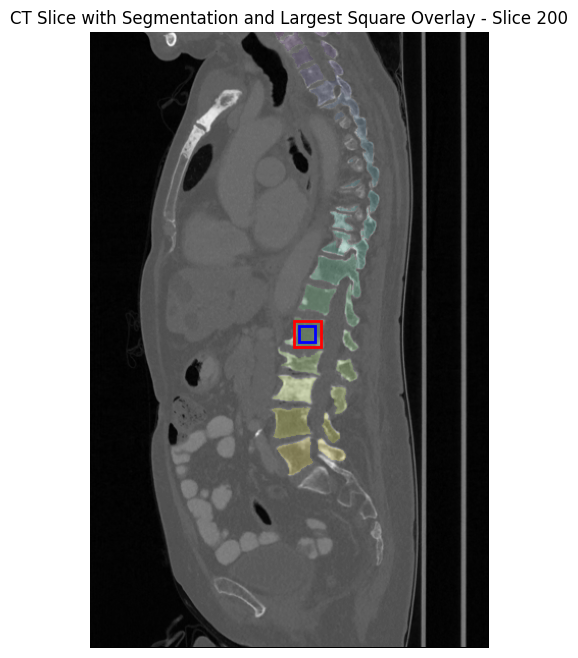

In [84]:

def plot_segmentation_with_square(ct_path, segmentation_path, target_value=20, shrink_size=5):
    ct_image = load_nifti_file(ct_path)
    segmentation = load_nifti_file(segmentation_path)

    max_square_size, best_position, best_slice_index = 0, (0, 0), 0
    for slice_index in range(segmentation.shape[2]):
        square_size, position = find_largest_square_in_slice(segmentation[:, :, slice_index], target_value)
        if square_size > max_square_size:
            max_square_size = square_size
            best_position = position
            best_slice_index = slice_index

    ct_slice = ct_image[:, :, best_slice_index]
    seg_slice = segmentation[:, :, best_slice_index]
    seg_mask = np.ma.masked_where(seg_slice == 0, seg_slice)

    plt.figure(figsize=(8, 8))
    plt.imshow(ct_slice, cmap='gray')
    plt.imshow(seg_mask, cmap='viridis', alpha=0.2)

    max_i, max_j = best_position
    plt.gca().add_patch(plt.Rectangle((max_j - max_square_size + 1, max_i - max_square_size + 1),
                                      max_square_size, max_square_size, edgecolor='red', facecolor='none', linewidth=2))

    # Calculate the inner square properties
    inner_square_size = max_square_size - 2 * shrink_size
    half_shrink_size = shrink_size
    inner_position = (max_j - max_square_size + 1 + half_shrink_size, max_i - max_square_size + 1 + half_shrink_size)

    # Print debugging information
    print(f"Largest square size: {max_square_size}, Position: {best_position}, Inner square size: {inner_square_size}")

    if inner_square_size > 0:  # Check if the inner square is valid
        plt.gca().add_patch(plt.Rectangle(inner_position, inner_square_size, inner_square_size,
                                          edgecolor='blue', facecolor='none', linewidth=2))
        smaller_square_ct = ct_slice[max_i - max_square_size + 1 + half_shrink_size : max_i - max_square_size + 1 + half_shrink_size + inner_square_size,
                                     max_j - max_square_size + 1 + half_shrink_size : max_j - max_square_size + 1 + half_shrink_size + inner_square_size]
        average_hounsfield_units = np.mean(smaller_square_ct)
        print(f"Average Hounsfield Units in the inner square: {average_hounsfield_units:.2f}")
    else:
        print("Inner square is too small to be plotted or calculated.")

    plt.axis('off')
    plt.title(f'CT Slice with Segmentation and Largest Square Overlay - Slice {best_slice_index}')
    plt.show()

# Example usage
plot_segmentation_with_square(image_path, label_path, shrink_size=5)
